# Pair programming A/B testing

In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np


# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") # establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_theme(style="dark") # cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
plt.style.use('Solarize_Light2')# establece el estilo en Solarize_Lihgt2. 

# Realizar los distintos test
# ------------------------------------------------------------------------------
from scipy import stats
from scipy.stats import ttest_ind, norm, chi2_contingency, f_oneway, fligner
from sklearn.linear_model import LinearRegression

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## Ejercicio 1:

Queremos determinar si un nuevo diseño de anuncio <span style="color:#D4AF37">test group "ad"</span> tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior <span style="color:#D4AF37">test group "psa"</span>.

**Objetivo del ejercicio**: 

Comparar las **tasas de conversión** entre los grupos de prueba "ad" y "psa" para **determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios**.

### 1.1 Preparación de los datos:
Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [2]:
df = pd.read_csv("marketing_AB.csv", index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
# Modifico título de columnas para que no haya espacios para mejor lectura
columnas = [col.replace(" ", "_") for col in df.columns]
df.columns = columnas
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [4]:
display(pd.DataFrame(df["test_group"].value_counts()))

,count
test_group,
ad,564577
psa,23524


In [5]:
# Crear función para exploración inicial del conjunto de datos

def exploracion_dataframe(dataframe, columna_control):
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("-"*100)

    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("-"*100)
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("-"*100)
    print("Los valores que tenemos para las columnas categóricas son:")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"\n * La columna {col} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()))    
    
    # para el A/B testing sacamos estadísticas de las principales categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("-"*100)
        print(f"Los principales estadísticos de las columnas categóricas para {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("-"*100)
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [6]:
# Nuestra columna control será test_group
exploracion_dataframe(df,"test_group")

Los duplicados que tenemos en el conjunto de datos son: 0
----------------------------------------------------------------------------------------------------
Los nulos que tenemos en el conjunto de datos son:


,%_nulos


----------------------------------------------------------------------------------------------------
Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,bool
total_ads,int64
most_ads_day,object
most_ads_hour,int64


----------------------------------------------------------------------------------------------------
Los valores que tenemos para las columnas categóricas son:

 * La columna test_group tiene las siguientes valore únicos:


,count
test_group,
ad,564577
psa,23524



 * La columna most_ads_day tiene las siguientes valore únicos:


,count
most_ads_day,
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660
Wednesday,80908
Tuesday,77479


----------------------------------------------------------------------------------------------------
Los principales estadísticos de las columnas categóricas para AD son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805


----------------------------------------------------------------------------------------------------
Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total_ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0


----------------------------------------------------------------------------------------------------
Los principales estadísticos de las columnas categóricas para PSA son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905


----------------------------------------------------------------------------------------------------
Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total_ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most_ads_hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


In [7]:
# según lo anterior no tenemos nulos ni duplicados

In [8]:
# el tipo de dato de la columna 'converted' es "bool".
# lo convertimos a 0 y 1 para poder realizar nuestro A-B testing

# Diccionario para reemplazar True por 1 y False por 0
reemplazo = {True: 1, False: 0}

# Aplicar el reemplazo a la columna 'converted'
df['converted'] = df['converted'].replace(reemplazo)
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


### 1.2 Definición de las hipótesis:
> - **Hipótesis nula (H0)**: No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
> - **Hipótesis alternativa (H1)**: Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

### 1.3 Cálculo de la tasa de conversión: 
Calcula la **tasa de conversión** para cada grupo:
 - Para el grupo "ad", la tasa de conversión es el **número de usuarios convertidos dividido por el número total de usuarios en ese grupo**.
 - Para el grupo "psa", la tasa de conversión es el **número de usuarios convertidos dividido por el número total de usuarios en ese grupo**.

In [9]:
# en la columna modificada 'converted' tenemos 1 = True, lo que nos facilita los cálculos

# según lo anterior, calculamos la tasa de conversión CR para cada grupo

# Filtrar datos por el grupo 'ad' y 'psa'
df_ad = df[df['test_group'] == 'ad']
df_psa = df[df['test_group'] == 'psa']

# Calcular la tasa de conversión para el grupo 'ad'
conversion_ad = df_ad['converted'].sum() / len(df_ad)
tasa_conversion_ad = round(conversion_ad * 100, 2)
print(f"Tasa de conversión CR para el grupo 'ad': {tasa_conversion_ad:.2f}%")

# Calcular la tasa de conversión para el grupo 'psa'
conversion_psa = df_psa['converted'].sum() / len(df_psa)
tasa_conversion_psa = round(conversion_psa * 100, 2)
print(f"Tasa de conversión CR para el grupo 'psa': {tasa_conversion_psa:.2f}%")

Tasa de conversión CR para el grupo 'ad': 2.55%
Tasa de conversión CR para el grupo 'psa': 1.79%


### 1.4 Prueba de hipótesis:
Utiliza una prueba estadística, como la prueba <span style="color:#D4AF37"> t de Student</span> o la prueba <span style="color:#D4AF37">chi-cuadrado</span>, para comparar las tasas de conversión entre los grupos "ad" y "psa".

In [10]:
# Recordamos el tamaño de la muestra
num_filas, num_columnas = df.shape

print(f"El tamaño de la muestra es de {num_filas} registros, por lo que utilizaremos la Prueba de Proporciones (chi2-contingency).\nAdemás, queremos comparar la Tasa de Conversión por grupo, dato que expresa proporciones")

El tamaño de la muestra es de 588101 registros, por lo que utilizaremos la Prueba de Proporciones (chi2-contingency).
Además, queremos comparar la Tasa de Conversión por grupo, dato que expresa proporciones


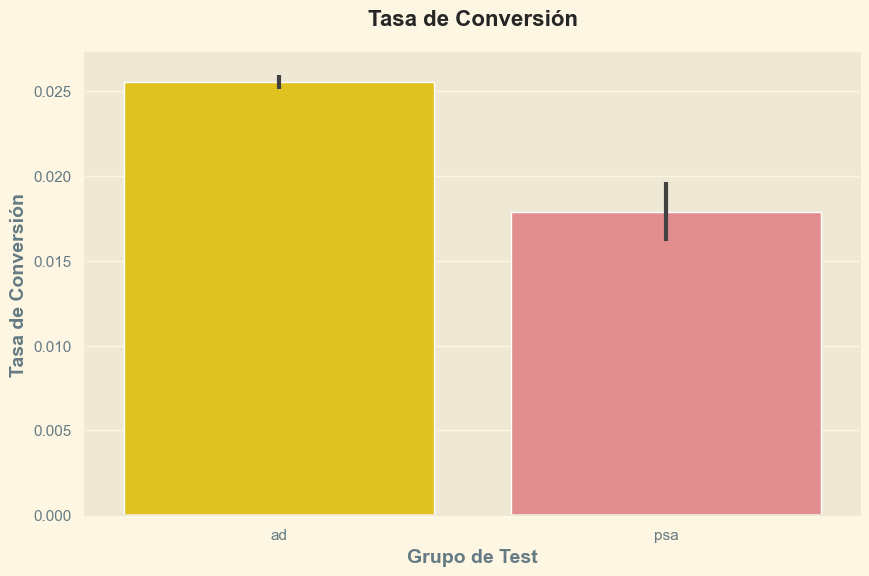

In [11]:
# Vamos a realizar un análisis visual previo
# Recordamos la modificación de los valores de la columna "converted" (1 == True , 0 == False)

# Crear gráfico de barras para la Tasa de Conversión (CR)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Definir colores para las barras
colores = {'ad': 'gold', 'psa': 'lightcoral'}

# Gráfico Tasa de Conversión
sns.barplot(x="test_group", y="converted", data=df, ax=axes, palette=colores)

# Configuración de los títulos
axes.set_title("Tasa de Conversión", fontsize=16, fontweight='bold', pad=20)
axes.set_xlabel("Grupo de Test", fontsize=14, fontweight='bold')
axes.set_ylabel("Tasa de Conversión", fontsize=14, fontweight='bold')

plt.show()

> **CONCLUSIONES**: Los datos mostrados en la gráfica sugieren que la tasa de conversión de anuncio original es mayor que el anuncio nuevo. Esto sugiere que la proporción de usuarios que realizan una compra efectiva es mayor cuando visionan el anuncio original.

In [12]:
#Creamos una función para el cálculo del Test de chi-cuadrado
def statistics_test(column1, column2):

    # Crear una tabla de contingencia
    contingency_table = pd.crosstab(column1, column2)

    # Ejecutar el test de chi-cuadrado
    chi2, p_valor, _, _ = chi2_contingency(contingency_table)

    # Mostrar los resultados del test
    print("\nResultados del test de Chi-cuadrado:")
    print(f"Estadística de Chi-cuadrado: {chi2}")
    print(f"P-valor: {p_valor}")

    # Interpretación del resultado
    alpha = 0.05  # Nivel de significancia
    if p_valor < alpha:
        print("\nExiste una diferencia significativa en la tasa de conversión entre el grupo ad y el psa. \n Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas.\n Según esto, nuestro nuevo anuncio tiene los efectos deseados y deberíamos cambiar la nueva versión de anuncios")
    
    else:
        print("\nNo existe suficiente evidencia entre la tasa de conversión de los dos grupos.\n Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas, por lo que la nueva campaña no está consiguiendo mayor tasa de conversión que la campaña anterior.")

### 1.5 Análisis de resultados:
 - Si el valor <span style="color:#D4AF37">p es menor que un umbral predefinido (por ejemplo, 0.05)</span>, rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.
 - Si el valor <span style="color:#D4AF37">p es mayor que el umbral</span>, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

In [13]:
statistics_test(df['converted'], df['test_group'])


Resultados del test de Chi-cuadrado:
Estadística de Chi-cuadrado: 54.005823883685245
P-valor: 1.9989623063390075e-13

Existe una diferencia significativa en la tasa de conversión entre el grupo ad y el psa. 
 Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas.
 Según esto, nuestro nuevo anuncio tiene los efectos deseados y deberíamos cambiar la nueva versión de anuncios


### 1.6 Conclusiones y recomendaciones: 

Basándote en los resultados de la prueba de hipótesis, llega a una <span style="color:#D4AF37">conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios </span>que el diseño anterior. 

Si es así, puedes hacer <span style="color:#D4AF37">recomendaciones basadas en estos hallazgos</span>.

> CONCLUSIÓN: el análisis estadístico sugiere la validez de la **Hipótesis alternativa (H1)** que postula que existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
Basándonos en este estudio, 

## Ejercicio 2:
Comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

### Objetivo del experimento: 
Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

### Preparación de los datos: 
Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

### Hipótesis: 
Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

### Análisis de resultados:
 - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.
 - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

### Conclusiones y recomendaciones:
 - Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario.
 - Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

Antes de realizar el test estadístico correspondiente, analizamos si nuestros datos cumplen con los supuestos de:
- Normalidad

- Homogeneidad de varianzas

- Independecia de las observaciones

In [14]:
# Verificar el número de muestras en cada grupo
print("Número de muestras en el grupo 'ad':", len(df_ad))
print("Número de muestras en el grupo 'psa':", len(df_psa))

Número de muestras en el grupo 'ad': 564577
Número de muestras en el grupo 'psa': 23524


> Por un lado, la <span style="color:#D4AF37">**prueba de homogeneidad de varianzas**</span> es más útil cuando se comparan grupos con tamaños de muestra de tamaños similares.
> Al ser el número de muestras del grupo "ad" mucho mayor que el del grupo "psa", vamos a utilizar la <span style="color:#D4AF37">**prueba de Fligner-Killeen**</span> en lugar de la prueba de Levene.
> La prueba de Fligner-Killeen <span style="color:#D4AF37">**es menos sensible a desviaciones de la normalidad**</span> y puede ser más apropiada cuando las muestras tienen diferentes tamaños.

> Dado que el número de muestras es grande, <span style="color:#D4AF37">descartamos realizar la prueba estadística t</span>

In [19]:
# creamos una clase para realizar todos los cálculos a la vez

# Crear la clase Data_Analysis
class Data_Analysis:
    @staticmethod
    def normalidad(dataframe, columna, grupo):
        statistic, p_value = stats.shapiro(dataframe[columna])
        if p_value > 0.05:
            print(f"Para el grupo '{grupo}', los datos en la columna '{columna}' siguen una distribución normal.")
            print(f'{grupo}')
        else:
            print(f"Para el grupo '{grupo}', los datos en la columna '{columna}' no siguen una distribución normal.")
            print(f'{grupo}')
    """
    @staticmethod
    def homogeneidad_levene(dataframe, columna, columna_metrica):
        valores_evaluar = []
        for valor in dataframe[columna].unique():
            valores_evaluar.append(dataframe[dataframe[columna] == valor][columna_metrica])

        statistic, p_value = stats.levene(*valores_evaluar)
        if p_value > 0.05:
            print(f"Para la métrica {columna_metrica}, las varianzas son homogéneas entre grupos.")
        else:
            print(f"Para la métrica {columna_metrica}, las varianzas no son homogéneas entre grupos.")
    """
    
    @staticmethod
    def homogeneidad_fligner (dataframe, columna, nombre_columna_grupo, control_group, test_group):
        # Filtrar el DataFrame para obtener los grupos específicos
        df_control_group = dataframe[dataframe[nombre_columna_grupo] == control_group]
        df_test_group = dataframe[dataframe[nombre_columna_grupo] == test_group]

        # Ejecutar la prueba de Fligner-Killeen
        statistic, p_value = fligner(df_control_group[columna], df_test_group[columna])

        # Mostrar los resultados
        if p_value > 0.05:
            print("Las varianzas son homogéneas entre los grupos.")
        else:
            print("Las varianzas no son homogéneas entre los grupos.")
        print(f"Estadístico de la prueba: {statistic}, p-valor: {p_value}")

    @staticmethod
    def visualizar_matriz_correlacion(dataframe, nombre_columna_grupo):
        # Filtrar el DataFrame para cada grupo
        control_group = dataframe[dataframe[nombre_columna_grupo] == 'ad']
        test_group = dataframe[dataframe[nombre_columna_grupo] == 'psa']

        # Calcular la matriz de correlación para cada grupo
        correlacion_matrix_grupo1 = control_group.corr(numeric_only=True)
        correlacion_matrix_grupo2 = test_group.corr(numeric_only=True)

        # Crear el heatmap para cada grupo
        sns.heatmap(correlacion_matrix_grupo1, annot=True, cmap="cubehelix", fmt=".2f")
        plt.title(f"Matriz de Correlación para grupo ad")
        plt.show()

        sns.heatmap(correlacion_matrix_grupo2, annot=True, cmap="cubehelix", fmt=".2f")
        plt.title(f"Matriz de Correlación para grupo psa")
        plt.show()

    @staticmethod
    def prueba_chi_cuadrado(dataframe, columna1, columna2):
        contingency_table = pd.crosstab(dataframe[columna1], dataframe[columna2])
        chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
        print(f"Prueba de Chi-cuadrado - p-valor: {p_chi2}")
    
    
    @staticmethod

    def prueba_t(dataframe, nombre_columna_grupo, columna_prueba):
        # Filtrar el dataframe para obtener el grupo de control y el grupo de prueba
        control_group = dataframe[dataframe[nombre_columna_grupo] == 'ad'][columna_prueba]
        test_group = dataframe[dataframe[nombre_columna_grupo] == 'psa'][columna_prueba]
        
        # Realizar la prueba t de independencia
        t_stat, p_ttest = ttest_ind(control_group, test_group, equal_var=False)  # Se asume varianzas no iguales
        
        # Imprimir el resultado
        print(f"Prueba t para la tasa de conversión entre el anuncio original y el nuevo arroja un p-valor: {p_ttest}")



Para el grupo 'ad', los datos en la columna 'converted' no siguen una distribución normal.
ad
Para el grupo 'psa', los datos en la columna 'converted' no siguen una distribución normal.
psa
Las varianzas no son homogéneas entre los grupos.
Estadístico de la prueba: 54.317959229610764, p-valor: 1.705360870194379e-13


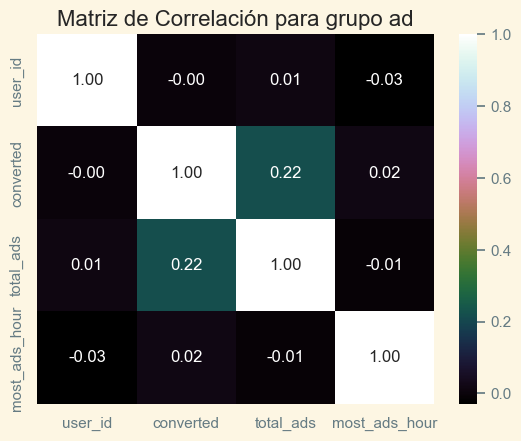

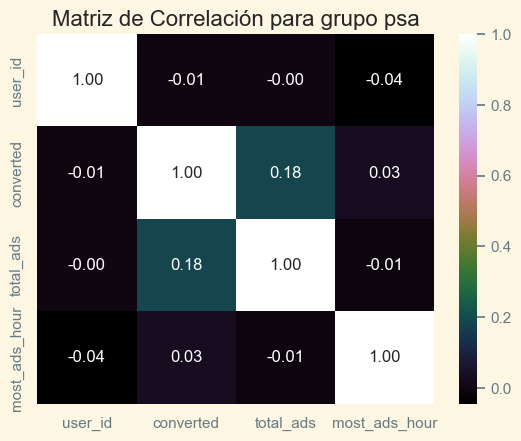

Prueba de Chi-cuadrado - p-valor: 1.9989623063390075e-13
Prueba t para la tasa de conversión entre el anuncio original y el nuevo arroja un p-valor: 5.107607598758945e-18


In [20]:
# Aplicamos las funciones de la clase a nuestros datos

# Filtrar por grupos 'ad' y 'psa'
df_ad = df[df['test_group'] == 'ad']
df_psa = df[df['test_group'] == 'psa']

# Instanciar la clase Data_Analysis
analisis = Data_Analysis()

# Ejecutar cada función de la clase Data_Analysis con los datos filtrados
analisis.normalidad(df, 'converted', 'ad')
analisis.normalidad(df, 'converted', 'psa')

"""
analisis.homogeneidad_levene(df_ad, 'test_group', 'converted')
analisis.homogeneidad_levene(df_psa, 'test_group', 'converted')
"""

analisis.homogeneidad_fligner(df, 'converted', 'test_group', 'ad', 'psa')

analisis.visualizar_matriz_correlacion(df, 'test_group')

analisis.prueba_chi_cuadrado(df, 'test_group', 'converted')

# Llamar a la función con los parámetros adecuados
analisis.prueba_t(df, 'test_group', 'converted')
